Guillermo Blanco Núñez <br>
Pablo Díaz Blanco<br>
ap-2526-p3-ap-11-01


# Práctica 3: RNNs

## Objetivo

Los objetivos de la práctica son:
1. Diseñar y entrenar una red neuronal residual lineal para un problema de clasificación binaria.
2. Implementar un método de fine-tuning eficiente que permita adaptar el modelo a una variante del
problema sin volver a entrenar todos los parámetros.
3. Analizar las ventajas y limitaciones del método

## Preparación del dataset


Importa todas las librerías necesarias.

In [1]:
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import balanced_accuracy_score, f1_score

Función para cargar archivos .pkl (pickle).

In [133]:
def load_pkl(path):
    with open(path, "rb") as f:
        return pickle.load(f)

Importa el split del dataset Higgs, descargado del aula virtual.

In [134]:
DATA_PATH = "../Higgs_DS/"

train_file = os.path.join(DATA_PATH, "higgs_train.pkl")
test_file  = os.path.join(DATA_PATH, "higgs_test.pkl")
extra_file = os.path.join(DATA_PATH, "higgs_extra.pkl")



train_data = load_pkl(train_file)
test_data  = load_pkl(test_file)
extra_data = load_pkl(extra_file)


Comprueba que el conjunto de datos esté correctamente importado al mostrar por pantalla esta información del mismo.

In [135]:
print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Extra shape:", extra_data.shape)

Train shape: (2000000, 29)
Test shape: (500000, 29)
Extra shape: (2000000, 29)


Convertir a arrays de numpy y separar los datos de las etiquetas

In [136]:
train_np = np.asarray(train_data)
test_np  = np.asarray(test_data)

y = train_np[:, 0].astype(np.float32)   
X = train_np[:, 1:].astype(np.float32)     

y_test = test_np[:, 0].astype(np.float32)         
X_test = test_np[:, 1:].astype(np.float32)  

Creación de train y validation

In [137]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

Calculo de la media y la desviación típica y aplicar normalización estándar

In [138]:
mean_train = X_train.mean(axis=0)
std_train  = X_train.std(axis=0)

std_train_safe = np.where(std_train == 0, 1.0, std_train)

X_train_norm = (X_train - mean_train) / std_train_safe
X_val_norm   = (X_val   - mean_train) / std_train_safe
X_test_norm  = (X_test  - mean_train) / std_train_safe


Comprobación:

In [141]:
print("Train:", X_train_norm.shape, y_train.shape)
print("Val:  ", X_val_norm.shape,   y_val.shape)
print("Test: ", X_test_norm.shape,  y_test.shape)

print("\nMedia primeras 5 features del TRAIN normalizado:")
print(X_train_norm.mean(axis=0)[:3])

print("\nSTD primeras 5 features del TRAIN normalizado:")
print(X_train_norm.std(axis=0)[:3])


Train: (1600000, 28) (1600000,)
Val:   (400000, 28) (400000,)
Test:  (500000, 28) (500000,)

Media primeras 5 features del TRAIN normalizado:
[-2.7320066e-05  4.5669823e-09 -3.4048259e-08]

STD primeras 5 features del TRAIN normalizado:
[0.9999674 1.0000007 1.0000387]


## Definición de los hiperparámetros
- Constantes: 
    1. EPOCHS: número máximo de épocas de entrenamiento para cada configuración.
    2. BATCH_SIZE: número de ejemplos que se procesan juntos en cada actualización de pesos.
    3. INPUT_SIZE: número de características de entrada (columnas) del dataset Higgs
    4. USE_EARLY_STOPPING: indica si se usa parada temprana para evitar sobreentrenar.
    5. PATIENCE: número de épocas sin mejora permitido antes de activar el early stopping.

- Cada tupla de la lista hyperparams representa un conjunto de hiperparámetros con la forma:
    
    (used_dim, n_blocks, opt_name, dropout, use_batchnorm)
- Explicación de cada uno:
    1. used_dim: tamaño del espacio interno, es decir, número de neuronas en cada capa densa de los bloques residuales. 
    2. n_blocks: número de bloques residuales encadenados. Cada bloque incluye dos capas lineales y una conexión residual.
    3. opt_name: tipo de optimizador utilizado.
    4. dropout: porcentaje de neuronas que se apagan aleatoriamente tras la activación (solo cuando no se usa BatchNorm).
    5. use_batchnorm: booleano que indica si se aplica Batch Normalization en las capas densas. 

In [103]:
EPOCHS = 25
BATCH_SIZE = 512
INPUT_SIZE = X_train_norm.shape[1]
PATIENCE = 5

hyperparams = [
    (64,  2, "Adam",    0.0, False),
    (64,  2, "Adam",    0.2, False),
    (128, 2, "Adam",    0.0, False),
    (128, 2, "Adam",    0.3, False),

    (64,  2, "Adam",    0.0, True),
    (128, 3, "Adam",    0.0, True),

    (64,  2, "RMSprop", 0.0, False),
    (64,  3, "SGD",     0.0, False),
]


In [142]:
EPOCHS = 25
BATCH_SIZE = 512
INPUT_SIZE = X_train_norm.shape[1]
PATIENCE = 5

hyperparams2 = [

    (32, 2, "Adam", 0.0, False, 0.0),
    (32, 2, "Adam", 0.0, False, 1e-5),

    (64, 2, "Adam", 0.0, False, 0.0),
    (64, 2, "Adam", 0.0, False, 1e-5),
        
    (64,  2, "Adam", 0.0, True,  0.0),
    (64,  2, "Adam", 0.0, True,  1e-5),

    (128, 2, "Adam", 0.0, False, 0.0),
    (128, 2, "Adam", 0.0, False, 1e-5),

    (128, 2, "Adam", 0.0, True, 0.0),   
    (128, 2, "Adam", 0.0, True, 1e-5),  
]

## Construcción de una red residual
- build_residual_MLP: construye y compila una red residual densa con bloques residuales para el problema de clasificación binaria del dataset Higgs. Recibe como entrada el tamaño del vector de características y los hiperparámetros del modelo. Primero crea una capa de entrada y otra densa inicial. Luego construye n_blocks capas residuales, donde cada una tiene dos capas lineales. El resultado de esto se suma a la entrada original aplicando ReLU al final. Por último, añade una capa Dense con activación sigmoide para clasifiación binaria. Selecciona el optimizador y crea el callback de early stopping. Los parámetros son:
    1. input_size: número de características de entrada.
    2. used_dim: número de neuronas en las capas densas internas de la red
    3. n_blocks: número de bloques residuales encadenados. 
    4. opt_name: nombre del optimizador a utilizar para el entrenamiento.
    5. dropout: tasa de dropout aplicada tras la activación cuando no se usa Batch Normalization.
    6. use_batchnorm: booleano que indica si se aplica Batch Normalization en las capas densas.
    7. use_early_stopping: indica si se debe crear y devolver un callback de parada temprana (EarlyStopping) junto con el modelo.
    8. patience: número de épocas sin mejora en la métrica de validación permitidas antes de activar el early stopping.

In [143]:
def build_residual_MLP(input_size, used_dim, n_blocks, opt_name, dropout, use_batchnorm, l2_reg):

    if use_batchnorm and dropout > 0.0:
        print("[AVISO] use_batchnorm=True y dropout>0. Ignorando dropout para no mezclar BN y Dropout.")
        dropout = 0.0

    inputs = layers.Input(shape=(input_size,))

    x = layers.Dense(used_dim, kernel_regularizer=regularizers.l2(l2_reg))(inputs)

    if use_batchnorm:
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
    else:
        x = layers.ReLU()(x)
        if dropout > 0.0:
            x = layers.Dropout(dropout)(x)

    for i in range(n_blocks):
        residual = x  

        z = layers.Dense(used_dim, kernel_regularizer= regularizers.l2(l2_reg))(x)
        if use_batchnorm:
            z = layers.BatchNormalization()(z)
            z = layers.ReLU()(z)
        else:
            z = layers.ReLU()(z)
            if dropout > 0.0:
                z = layers.Dropout(dropout)(z)

        z = layers.Dense(used_dim, kernel_regularizer=regularizers.l2(l2_reg))(z)
        if use_batchnorm:
            z = layers.BatchNormalization()(z)

        x = layers.Add()([residual, z])
        x = layers.ReLU()(x)

    outputs = layers.Dense(1, activation="sigmoid", kernel_regularizer=regularizers.l2(l2_reg))(x)
    model = Model(inputs, outputs)

    if opt_name == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    elif opt_name == "SGD":
        opt = tf.keras.optimizers.SGD(learning_rate=0.03, momentum=0.9)
    elif opt_name == "RMSprop":
        opt = tf.keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9)
    else:
        raise ValueError(f"Optimiser '{opt_name}' not supported")

    model.compile(optimizer=opt)

    
    return model


In [144]:
def stats_residual(history):

    TrainAcc  = np.array([h["TrainAcc"]  for h in history])
    ValAcc    = np.array([h["ValAcc"]    for h in history])
    TrainLoss = np.array([h["TrainLoss"] for h in history])
    ValLoss   = np.array([h["ValLoss"]   for h in history])

    best_idx = int(np.argmax(ValAcc))
    best_ep  = history[best_idx]["epoch"]  

    print(
        f"\n>> Mejor época: {best_ep}  "
        f"TrainAcc={TrainAcc[best_idx]:.4f}  "
        f"ValAcc={ValAcc[best_idx]:.4f}  "
        f"TrainLoss={TrainLoss[best_idx]:.4f}  "
        f"ValLoss={ValLoss[best_idx]:.4f}  "
        f"(épocas ejecutadas={len(history)})"
    )

    print("\n--- Estadísticas generales ---")
    metrics = {
        "TrainAcc":  TrainAcc,
        "ValAcc":    ValAcc,
        "TrainLoss": TrainLoss,
        "ValLoss":   ValLoss,
    }

    for name in ["TrainAcc", "ValAcc", "TrainLoss", "ValLoss"]:
        values = metrics[name]
        mean   = float(values.mean())
        median = float(np.median(values))
        print(f"{name:>12}: media={mean:.4f}, mediana={median:.4f}")

    fig = plt.figure(figsize=(10, 4))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(TrainLoss, label='Train loss')
    ax1.plot(ValLoss,   label='Val loss')
    ax1.set_title('Loss por época')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(TrainAcc, label='Train acc')
    ax2.plot(ValAcc,   label='Val acc')
    ax2.set_title('Accuracy por época')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, 1)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return best_ep


In [145]:
def make_datasets(X_train, y_train, X_val, y_val, batch_size):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_ds = train_ds.shuffle(buffer_size=len(X_train)).batch(batch_size)

    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_ds = val_ds.batch(batch_size)

    return train_ds, val_ds

In [146]:
def train_one_model(model, X_train, y_train, X_val, y_val, epochs=EPOCHS, batch_size=BATCH_SIZE, patience=PATIENCE):
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    TrainAcc_metric = tf.keras.metrics.BinaryAccuracy()
    ValAcc_metric = tf.keras.metrics.BinaryAccuracy()

    train_ds, val_ds = make_datasets(X_train, y_train, X_val, y_val, batch_size)

    history = []
    best_ValAcc = 0.0
    best_weights = model.get_weights()
    best_epoch = 0
    epochs_without_improve = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        TrainLoss_sum = 0.0
        train_steps = 0

        for step, (x_batch, y_batch) in enumerate(train_ds):
            with tf.GradientTape() as tape:
                logits = model(x_batch, training=True)
                loss_value = loss_fn(y_batch, logits)
                if model.losses:
                    loss_value += tf.add_n(model.losses)

            grads = tape.gradient(loss_value, model.trainable_weights)
            model.optimizer.apply_gradients(zip(grads, model.trainable_weights))

            TrainAcc_metric.update_state(y_batch, logits)

            TrainLoss_sum += float(loss_value.numpy())
            train_steps += 1

        TrainLoss = TrainLoss_sum / train_steps
        TrainAcc = float(TrainAcc_metric.result().numpy())
        TrainAcc_metric.reset_state()

        ValLoss_sum = 0.0
        val_steps = 0

        for x_batch_val, y_batch_val in val_ds:
            logits_val = model(x_batch_val, training=False)
            loss_val = loss_fn(y_batch_val, logits_val)
            if model.losses:
                loss_val += tf.add_n(model.losses)

            ValAcc_metric.update_state(y_batch_val, logits_val)

            ValLoss_sum += float(loss_val.numpy())
            val_steps += 1

        ValLoss = ValLoss_sum / val_steps
        ValAcc = float(ValAcc_metric.result().numpy())
        ValAcc_metric.reset_state()

        print(
            f"TrainLoss={TrainLoss:.4f}  "
            f"TrainAcc={TrainAcc:.4f}  "
            f"ValLoss={ValLoss:.4f}  "
            f"ValAcc={ValAcc:.4f}"
        )

        history.append(
            {
                "epoch": epoch + 1,
                "TrainLoss": TrainLoss,
                "TrainAcc": TrainAcc,
                "ValLoss": ValLoss,
                "ValAcc": ValAcc,
            }
        )

        if ValAcc > best_ValAcc + 1e-3:
            best_ValAcc = ValAcc
            best_epoch = epoch + 1
            best_weights = model.get_weights()
            epochs_without_improve = 0
        else:
            epochs_without_improve += 1
            if patience is not None and epochs_without_improve >= patience:
                print(
                    f"Early stopping: sin mejora en ValAcc durante {patience} épocas."
                )
                break

    return history, best_weights, best_epoch


In [148]:
def fit_residual(used_dim, n_blocks, opt_name, dropout, use_batchnorm, l2_reg):
    print(f"\n=== used_dim = {used_dim} | n_blocks = {n_blocks} |  Optimizer = {opt_name} | Dropout = {dropout} | BatchNorm = {use_batchnorm} | L2 = {l2_reg} ===")

    model = build_residual_MLP(
        input_size=INPUT_SIZE,
        used_dim=used_dim,
        n_blocks=n_blocks,
        opt_name=opt_name,
        dropout=dropout,
        use_batchnorm=use_batchnorm,
        l2_reg=l2_reg
    )

    start = time.perf_counter()
    history, best_weights, best_epoch = train_one_model(
        model,
        X_train_norm, y_train,
        X_val_norm, y_val,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        patience=PATIENCE
    )
    train_time = time.perf_counter() - start

    best_ep = stats_residual(history)
    model.set_weights(best_weights)

    TrainAcc_mean = float(np.mean([h["TrainAcc"] for h in history]))
    TrainLoss_mean = float(np.mean([h["TrainLoss"] for h in history]))

    loss_fn = tf.keras.losses.BinaryCrossentropy()
    logits_test = model(X_test_norm, training = False)
    TestLoss = float(loss_fn(y_test, logits_test).numpy())

    TestAcc_metric = tf.keras.metrics.BinaryAccuracy()
    TestAcc_metric.update_state(y_test, logits_test)
    TestAcc = float(TestAcc_metric.result().numpy())

    results = {
        "used_dim": used_dim,
        "n_blocks": n_blocks,
        "opt_name": opt_name,
        "dropout": dropout,
        "use_batchnorm": use_batchnorm,
        "l2_reg": l2_reg,
        "TrainAcc_mean": TrainAcc_mean,
        "TrainLoss_mean": TrainLoss_mean,
        "BestEpoch": best_epoch,
        "BestValAcc": float(max(h["ValAcc"] for h in history)),
        "TestAcc": TestAcc,
        "TestLoss": TestLoss,
        "Execution_time": train_time,
    }

    print(results)

    return model, best_weights, results



In [ ]:
models = []  
results = []


=== used_dim = 64 | n_blocks = 2 |  Optimizer = Adam | Dropout = 0.0 | BatchNorm = False ===

Epoch 1/25
TrainLoss=0.5596  TrainAcc=0.7074  ValLoss=0.5293  ValAcc=0.7307

Epoch 2/25
TrainLoss=0.5185  TrainAcc=0.7380  ValLoss=0.5118  ValAcc=0.7414

Epoch 3/25
TrainLoss=0.5075  TrainAcc=0.7451  ValLoss=0.5054  ValAcc=0.7469

Epoch 4/25
TrainLoss=0.5019  TrainAcc=0.7488  ValLoss=0.5024  ValAcc=0.7486

Epoch 5/25
TrainLoss=0.4981  TrainAcc=0.7511  ValLoss=0.4994  ValAcc=0.7505

Epoch 6/25
TrainLoss=0.4954  TrainAcc=0.7530  ValLoss=0.4952  ValAcc=0.7531

Epoch 7/25
TrainLoss=0.4931  TrainAcc=0.7543  ValLoss=0.4960  ValAcc=0.7538

Epoch 8/25
TrainLoss=0.4915  TrainAcc=0.7554  ValLoss=0.4941  ValAcc=0.7538

Epoch 9/25
TrainLoss=0.4900  TrainAcc=0.7565  ValLoss=0.4935  ValAcc=0.7546

Epoch 10/25
TrainLoss=0.4886  TrainAcc=0.7574  ValLoss=0.4912  ValAcc=0.7556

Epoch 11/25
TrainLoss=0.4875  TrainAcc=0.7581  ValLoss=0.4913  ValAcc=0.7555

Epoch 12/25
TrainLoss=0.4865  TrainAcc=0.7590  ValLoss=0

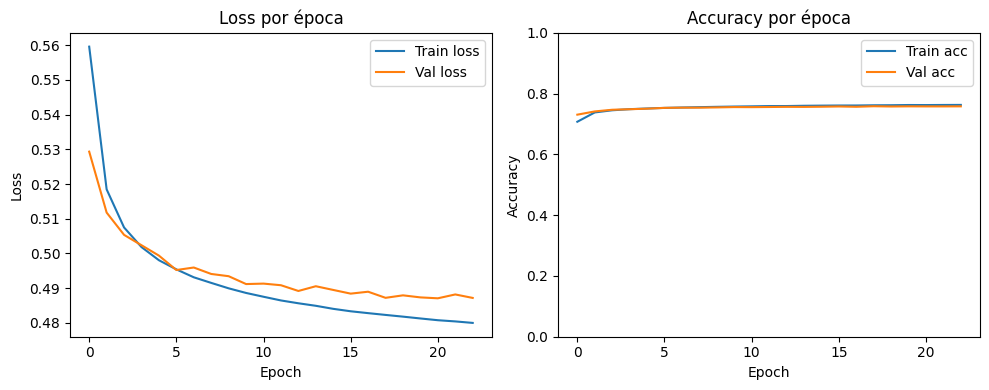

{'used_dim': 64, 'n_blocks': 2, 'opt_name': 'Adam', 'dropout': 0.0, 'use_batchnorm': False, 'TrainAcc_mean': 0.7547429385392562, 'TrainLoss_mean': 0.49241755903865975, 'BestEpoch': 18, 'BestValAcc': 0.7584325075149536, 'TestAcc': 0.7585440278053284, 'TestLoss': 0.4868681728839874, 'Execution_time': 3897.105362200178}

=== used_dim = 64 | n_blocks = 2 |  Optimizer = Adam | Dropout = 0.2 | BatchNorm = False ===

Epoch 1/25
TrainLoss=0.5879  TrainAcc=0.6834  ValLoss=0.5358  ValAcc=0.7268

Epoch 2/25
TrainLoss=0.5437  TrainAcc=0.7207  ValLoss=0.5240  ValAcc=0.7335

Epoch 3/25
TrainLoss=0.5342  TrainAcc=0.7267  ValLoss=0.5191  ValAcc=0.7372

Epoch 4/25
TrainLoss=0.5297  TrainAcc=0.7299  ValLoss=0.5143  ValAcc=0.7401

Epoch 5/25
TrainLoss=0.5265  TrainAcc=0.7319  ValLoss=0.5145  ValAcc=0.7401

Epoch 6/25
TrainLoss=0.5239  TrainAcc=0.7336  ValLoss=0.5111  ValAcc=0.7418

Epoch 7/25
TrainLoss=0.5222  TrainAcc=0.7346  ValLoss=0.5096  ValAcc=0.7430

Epoch 8/25
TrainLoss=0.5210  TrainAcc=0.7357  V

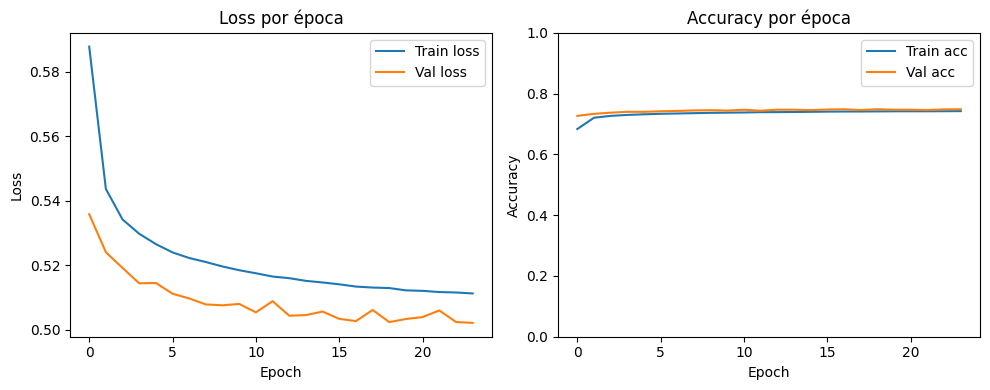

{'used_dim': 64, 'n_blocks': 2, 'opt_name': 'Adam', 'dropout': 0.2, 'use_batchnorm': False, 'TrainAcc_mean': 0.7350171854098638, 'TrainLoss_mean': 0.5216034037594001, 'BestEpoch': 19, 'BestValAcc': 0.7486249804496765, 'TestAcc': 0.7494199872016907, 'TestLoss': 0.5011533498764038, 'Execution_time': 5360.709943500115}

=== used_dim = 128 | n_blocks = 2 |  Optimizer = Adam | Dropout = 0.0 | BatchNorm = False ===

Epoch 1/25
TrainLoss=0.5445  TrainAcc=0.7192  ValLoss=0.5157  ValAcc=0.7401

Epoch 2/25
TrainLoss=0.5073  TrainAcc=0.7459  ValLoss=0.5022  ValAcc=0.7490

Epoch 3/25
TrainLoss=0.4965  TrainAcc=0.7528  ValLoss=0.4948  ValAcc=0.7539

Epoch 4/25
TrainLoss=0.4904  TrainAcc=0.7566  ValLoss=0.4925  ValAcc=0.7549

Epoch 5/25
TrainLoss=0.4861  TrainAcc=0.7592  ValLoss=0.4899  ValAcc=0.7569

Epoch 6/25
TrainLoss=0.4827  TrainAcc=0.7613  ValLoss=0.4874  ValAcc=0.7582

Epoch 7/25
TrainLoss=0.4800  TrainAcc=0.7635  ValLoss=0.4872  ValAcc=0.7593

Epoch 8/25
TrainLoss=0.4776  TrainAcc=0.7650  V

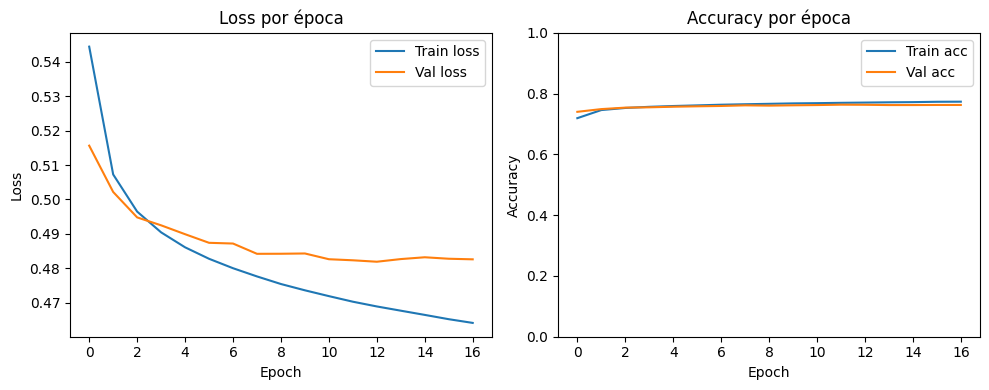

{'used_dim': 128, 'n_blocks': 2, 'opt_name': 'Adam', 'dropout': 0.0, 'use_batchnorm': False, 'TrainAcc_mean': 0.7621244122000301, 'TrainLoss_mean': 0.48166612055105323, 'BestEpoch': 12, 'BestValAcc': 0.7635675072669983, 'TestAcc': 0.7634940147399902, 'TestLoss': 0.48135751485824585, 'Execution_time': 3053.7819097000174}

=== used_dim = 128 | n_blocks = 2 |  Optimizer = Adam | Dropout = 0.3 | BatchNorm = False ===

Epoch 1/25
TrainLoss=0.5775  TrainAcc=0.6930  ValLoss=0.5302  ValAcc=0.7311

Epoch 2/25
TrainLoss=0.5375  TrainAcc=0.7249  ValLoss=0.5199  ValAcc=0.7363

Epoch 3/25
TrainLoss=0.5286  TrainAcc=0.7309  ValLoss=0.5163  ValAcc=0.7400

Epoch 4/25
TrainLoss=0.5240  TrainAcc=0.7338  ValLoss=0.5124  ValAcc=0.7416

Epoch 5/25
TrainLoss=0.5208  TrainAcc=0.7366  ValLoss=0.5079  ValAcc=0.7450

Epoch 6/25
TrainLoss=0.5186  TrainAcc=0.7378  ValLoss=0.5066  ValAcc=0.7457

Epoch 7/25
TrainLoss=0.5168  TrainAcc=0.7390  ValLoss=0.5068  ValAcc=0.7456

Epoch 8/25
TrainLoss=0.5155  TrainAcc=0.739

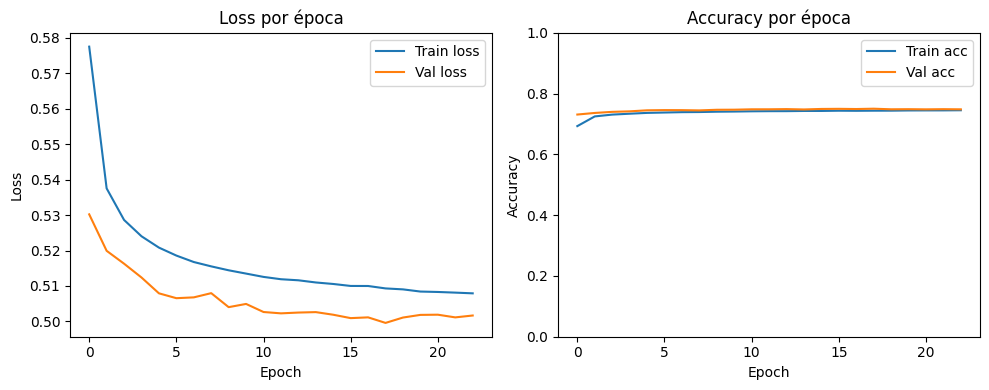

{'used_dim': 128, 'n_blocks': 2, 'opt_name': 'Adam', 'dropout': 0.3, 'use_batchnorm': False, 'TrainAcc_mean': 0.7383987748104593, 'TrainLoss_mean': 0.517221502247686, 'BestEpoch': 18, 'BestValAcc': 0.7503374814987183, 'TestAcc': 0.7508000135421753, 'TestLoss': 0.49846991896629333, 'Execution_time': 4931.944881699979}


In [104]:
for (used_dim, n_blocks, opt_name, dropout, use_batchnorm) in hyperparams[:4]:
    model, best_weights, result = fit_residual(used_dim, n_blocks, opt_name, dropout, use_batchnorm)
    models.append((model, best_weights))
    results.append(result)


=== used_dim = 64 | n_blocks = 2 |  Optimizer = Adam | Dropout = 0.0 | BatchNorm = True ===

Epoch 1/25
TrainLoss=0.5608  TrainAcc=0.7060  ValLoss=0.5297  ValAcc=0.7307

Epoch 2/25
TrainLoss=0.5181  TrainAcc=0.7381  ValLoss=0.5093  ValAcc=0.7440

Epoch 3/25
TrainLoss=0.5069  TrainAcc=0.7455  ValLoss=0.5029  ValAcc=0.7486

Epoch 4/25
TrainLoss=0.5013  TrainAcc=0.7490  ValLoss=0.4986  ValAcc=0.7507

Epoch 5/25
TrainLoss=0.4975  TrainAcc=0.7517  ValLoss=0.4952  ValAcc=0.7532

Epoch 6/25
TrainLoss=0.4949  TrainAcc=0.7535  ValLoss=0.4935  ValAcc=0.7542

Epoch 7/25
TrainLoss=0.4928  TrainAcc=0.7546  ValLoss=0.4917  ValAcc=0.7557

Epoch 8/25
TrainLoss=0.4912  TrainAcc=0.7560  ValLoss=0.4913  ValAcc=0.7555

Epoch 9/25
TrainLoss=0.4895  TrainAcc=0.7570  ValLoss=0.4909  ValAcc=0.7558

Epoch 10/25
TrainLoss=0.4883  TrainAcc=0.7578  ValLoss=0.4898  ValAcc=0.7563

Epoch 11/25
TrainLoss=0.4873  TrainAcc=0.7584  ValLoss=0.4890  ValAcc=0.7569

Epoch 12/25
TrainLoss=0.4861  TrainAcc=0.7590  ValLoss=0.

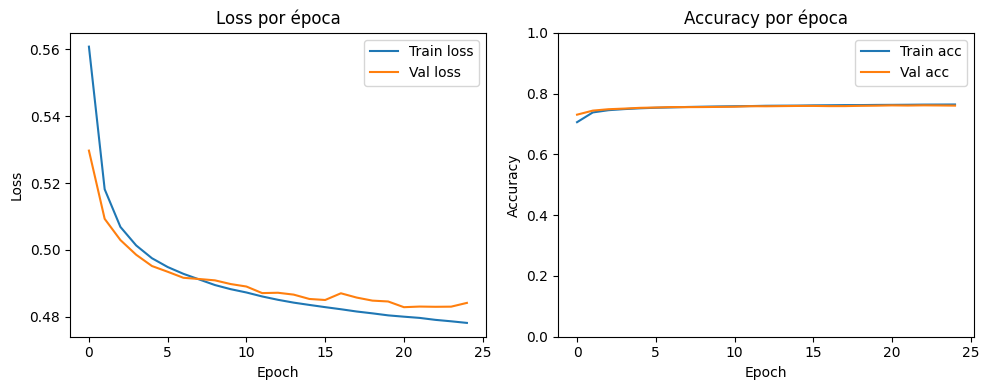

{'used_dim': 64, 'n_blocks': 2, 'opt_name': 'Adam', 'dropout': 0.0, 'use_batchnorm': True, 'TrainAcc_mean': 0.7558422470092774, 'TrainLoss_mean': 0.4908492888233185, 'BestEpoch': 23, 'BestValAcc': 0.7613700032234192, 'TestAcc': 0.7622560262680054, 'TestLoss': 0.48159852623939514, 'Execution_time': 8703.651415799977}

=== used_dim = 128 | n_blocks = 3 |  Optimizer = Adam | Dropout = 0.0 | BatchNorm = True ===

Epoch 1/25
TrainLoss=0.5504  TrainAcc=0.7153  ValLoss=0.5194  ValAcc=0.7371

Epoch 2/25
TrainLoss=0.5095  TrainAcc=0.7439  ValLoss=0.5029  ValAcc=0.7480

Epoch 3/25
TrainLoss=0.4982  TrainAcc=0.7512  ValLoss=0.4935  ValAcc=0.7541

Epoch 4/25
TrainLoss=0.4917  TrainAcc=0.7553  ValLoss=0.4916  ValAcc=0.7553

Epoch 5/25
TrainLoss=0.4870  TrainAcc=0.7583  ValLoss=0.4869  ValAcc=0.7582

Epoch 6/25
TrainLoss=0.4833  TrainAcc=0.7608  ValLoss=0.4851  ValAcc=0.7599

Epoch 7/25
TrainLoss=0.4801  TrainAcc=0.7633  ValLoss=0.4843  ValAcc=0.7605

Epoch 8/25
TrainLoss=0.4774  TrainAcc=0.7647  Va

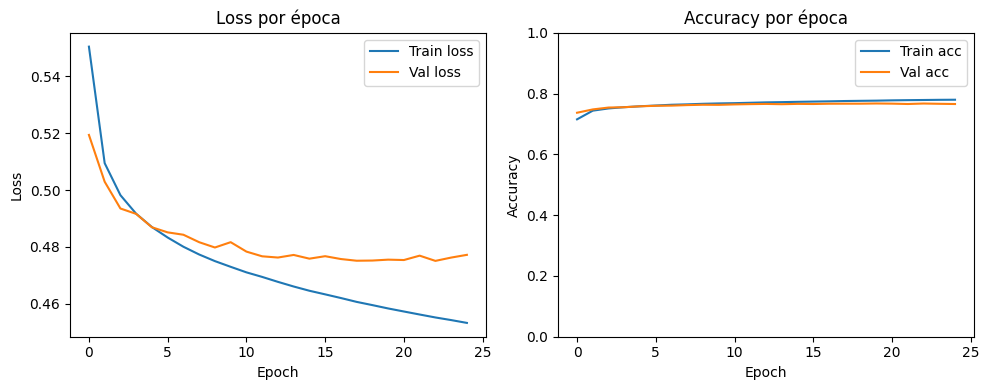

{'used_dim': 128, 'n_blocks': 3, 'opt_name': 'Adam', 'dropout': 0.0, 'use_batchnorm': True, 'TrainAcc_mean': 0.766934700012207, 'TrainLoss_mean': 0.47380597747993475, 'BestEpoch': 20, 'BestValAcc': 0.7675225138664246, 'TestAcc': 0.7668219804763794, 'TestLoss': 0.47496965527534485, 'Execution_time': 12744.743962399894}


In [105]:
for (used_dim, n_blocks, opt_name, dropout, use_batchnorm) in hyperparams[4:6]:
    model, best_weights, result = fit_residual(used_dim, n_blocks, opt_name, dropout, use_batchnorm)
    models.append((model, best_weights))
    results.append(result)


=== used_dim = 64 | n_blocks = 2 |  Optimizer = RMSprop | Dropout = 0.0 | BatchNorm = False ===

Epoch 1/25
TrainLoss=0.5607  TrainAcc=0.7069  ValLoss=0.5298  ValAcc=0.7313

Epoch 2/25
TrainLoss=0.5218  TrainAcc=0.7362  ValLoss=0.5147  ValAcc=0.7409

Epoch 3/25
TrainLoss=0.5096  TrainAcc=0.7438  ValLoss=0.5067  ValAcc=0.7452

Epoch 4/25
TrainLoss=0.5032  TrainAcc=0.7478  ValLoss=0.5024  ValAcc=0.7485

Epoch 5/25
TrainLoss=0.4993  TrainAcc=0.7504  ValLoss=0.5019  ValAcc=0.7486

Epoch 6/25
TrainLoss=0.4965  TrainAcc=0.7523  ValLoss=0.4966  ValAcc=0.7516

Epoch 7/25
TrainLoss=0.4943  TrainAcc=0.7539  ValLoss=0.4963  ValAcc=0.7525

Epoch 8/25
TrainLoss=0.4928  TrainAcc=0.7548  ValLoss=0.4948  ValAcc=0.7530

Epoch 9/25
TrainLoss=0.4915  TrainAcc=0.7560  ValLoss=0.4964  ValAcc=0.7524

Epoch 10/25
TrainLoss=0.4903  TrainAcc=0.7566  ValLoss=0.4915  ValAcc=0.7558

Epoch 11/25
TrainLoss=0.4892  TrainAcc=0.7573  ValLoss=0.4913  ValAcc=0.7557

Epoch 12/25
TrainLoss=0.4881  TrainAcc=0.7579  ValLos

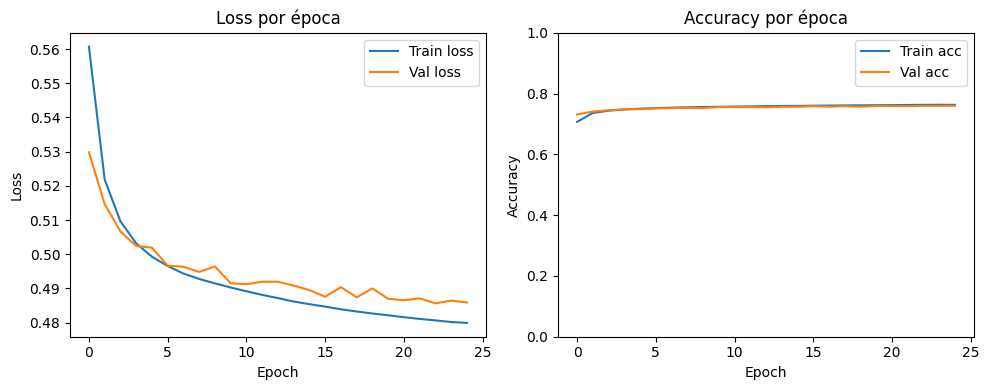

{'used_dim': 64, 'n_blocks': 2, 'opt_name': 'RMSprop', 'dropout': 0.0, 'use_batchnorm': False, 'TrainAcc_mean': 0.7548414492607116, 'TrainLoss_mean': 0.4926307214046478, 'BestEpoch': 25, 'BestValAcc': 0.7598850131034851, 'TestAcc': 0.7595599889755249, 'TestLoss': 0.48553404211997986, 'Execution_time': 3248.929225199856}

=== used_dim = 64 | n_blocks = 3 |  Optimizer = SGD | Dropout = 0.0 | BatchNorm = False ===

Epoch 1/25
TrainLoss=0.5631  TrainAcc=0.7043  ValLoss=0.5312  ValAcc=0.7293

Epoch 2/25
TrainLoss=0.5236  TrainAcc=0.7347  ValLoss=0.5177  ValAcc=0.7373

Epoch 3/25
TrainLoss=0.5130  TrainAcc=0.7414  ValLoss=0.5097  ValAcc=0.7434

Epoch 4/25
TrainLoss=0.5070  TrainAcc=0.7455  ValLoss=0.5074  ValAcc=0.7446

Epoch 5/25
TrainLoss=0.5029  TrainAcc=0.7480  ValLoss=0.5023  ValAcc=0.7488

Epoch 6/25
TrainLoss=0.4997  TrainAcc=0.7504  ValLoss=0.5017  ValAcc=0.7493

Epoch 7/25
TrainLoss=0.4971  TrainAcc=0.7519  ValLoss=0.4983  ValAcc=0.7507

Epoch 8/25
TrainLoss=0.4951  TrainAcc=0.7531 

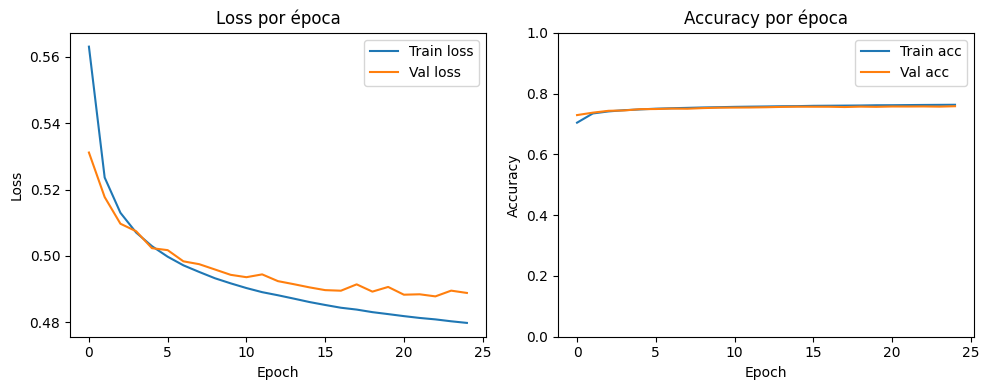

{'used_dim': 64, 'n_blocks': 3, 'opt_name': 'SGD', 'dropout': 0.0, 'use_batchnorm': False, 'TrainAcc_mean': 0.7537355971336365, 'TrainLoss_mean': 0.49397530138626095, 'BestEpoch': 25, 'BestValAcc': 0.7585049867630005, 'TestAcc': 0.7588539719581604, 'TestLoss': 0.4873887002468109, 'Execution_time': 3463.91344309994}


In [106]:
for (used_dim, n_blocks, opt_name, dropout, use_batchnorm) in hyperparams[6:8]:
    model, best_weights, result = fit_residual(used_dim, n_blocks, opt_name, dropout, use_batchnorm)
    models.append((model, best_weights))
    results.append(result)

Postprocesado primer bloque de hiperparametros

In [ ]:
SAVE_DIR_1 = "saved_models_hp1"
os.makedirs(SAVE_DIR_1, exist_ok=True)

y_true = np.asarray(y_test, dtype=int).ravel()

for i, (model, best_weights) in enumerate(models):
    print(f"\n[POST 1] Calculando métricas y guardando modelo #{i} ...")

    model.set_weights(best_weights)

    y_probabilities = model.predict(X_test_norm, verbose=0)
    y_scores = y_probabilities.ravel()

    y_pred = np.zeros_like(y_scores, dtype=int)
    for idx, prob in enumerate(y_scores):
        y_pred[idx] = 1 if prob >= 0.5 else 0

    bal_acc = balanced_accuracy_score(y_true, y_pred)
    f1      = f1_score(y_true, y_pred)

    results[i]["TestBalAcc"] = float(bal_acc)
    results[i]["TestF1"]     = float(f1)

    r = results[i]
    model_filename = (
        f"residual_hp1_dim{int(r['used_dim'])}"
        f"_blocks{int(r['n_blocks'])}"
        f"_opt{r['opt_name']}"
        f"_do{r['dropout']}"
        f"_bn{int(r['use_batchnorm'])}.keras"
    )

    model_path = os.path.join(SAVE_DIR_1, model_filename)
    model.save(model_path)


[POST 1] Calculando métricas y guardando modelo #0 ...

[POST 1] Calculando métricas y guardando modelo #1 ...

[POST 1] Calculando métricas y guardando modelo #2 ...

[POST 1] Calculando métricas y guardando modelo #3 ...

[POST 1] Calculando métricas y guardando modelo #4 ...

[POST 1] Calculando métricas y guardando modelo #5 ...

[POST 1] Calculando métricas y guardando modelo #6 ...

[POST 1] Calculando métricas y guardando modelo #7 ...


In [2]:
# df_resultados = pd.DataFrame(results)
df_resultados = pd.read_csv("resultados_higgs_residual.csv")
df_resultados = df_resultados[
    [
        "used_dim", "n_blocks", "opt_name", "dropout", "use_batchnorm",
        "TrainAcc_mean", "TrainLoss_mean",
        "BestEpoch", "BestValAcc",
        "TestAcc", "TestBalAcc", "TestF1", "TestLoss",
        "Execution_time"
    ]
]

# df_resultados.to_csv("resultados_higgs_residual.csv", index=False)


col_numericas = df_resultados.select_dtypes(include="number").columns

df_final = (
    df_resultados.style
        .set_caption("RESULTADOS FINALES - Redes Residuales Higgs")
        .background_gradient(cmap="YlGnBu", subset=["TestAcc"])   
        .background_gradient(cmap="OrRd",    subset=["TestLoss"])
        .background_gradient(cmap="YlGnBu", subset=["TestBalAcc"]) 
        .background_gradient(cmap="YlGnBu", subset=["TestF1"])  
        .highlight_max(color="darkgreen", subset=["TestAcc"])     
        .highlight_max(color="darkred",   subset=["TestLoss"])  
        .highlight_max(color="darkgreen", subset=["TestBalAcc"])     
        .highlight_max(color="darkgreen",   subset=["TestF1"])   
        .format({col: "{:.4g}".format for col in col_numericas})  
        .set_table_attributes('style="width:100%; table-layout:auto;"')
)

In [3]:
df_final

,used_dim,n_blocks,opt_name,dropout,use_batchnorm,TrainAcc_mean,TrainLoss_mean,BestEpoch,BestValAcc,TestAcc,TestBalAcc,TestF1,TestLoss,Execution_time
0,64,2,Adam,0,False,0.7547,0.4924,18,0.7584,0.7585,0.7575,0.7727,0.4869,3897
1,64,2,Adam,0.2,False,0.735,0.5216,19,0.7486,0.7494,0.7473,0.7678,0.5012,5361
2,128,2,Adam,0,False,0.7621,0.4817,12,0.7636,0.7635,0.7614,0.781,0.4814,3054
3,128,2,Adam,0.3,False,0.7384,0.5172,18,0.7503,0.7508,0.7479,0.7722,0.4985,4932
4,64,2,Adam,0,True,0.7558,0.4908,23,0.7614,0.7623,0.7612,0.7761,0.4816,8704
5,128,3,Adam,0,True,0.7669,0.4738,20,0.7675,0.7668,0.7648,0.784,0.475,1.274e+04
6,64,2,RMSprop,0,False,0.7548,0.4926,25,0.7599,0.7596,0.7567,0.7799,0.4855,3249
7,64,3,SGD,0,False,0.7537,0.494,25,0.7585,0.7589,0.759,0.7684,0.4874,3464


In [130]:
models2  = []
results2 = []


=== used_dim = 32 | n_blocks = 2 |  Optimizer = Adam | Dropout = 0.0 | BatchNorm = False | L2 = 0.0 ===

Epoch 1/25
TrainLoss=0.5754  TrainAcc=0.6943  ValLoss=0.5421  ValAcc=0.7219

Epoch 2/25
TrainLoss=0.5337  TrainAcc=0.7275  ValLoss=0.5271  ValAcc=0.7316

Epoch 3/25
TrainLoss=0.5232  TrainAcc=0.7347  ValLoss=0.5214  ValAcc=0.7359

Epoch 4/25
TrainLoss=0.5178  TrainAcc=0.7382  ValLoss=0.5173  ValAcc=0.7382

Epoch 5/25
TrainLoss=0.5144  TrainAcc=0.7403  ValLoss=0.5139  ValAcc=0.7401

Epoch 6/25
TrainLoss=0.5117  TrainAcc=0.7418  ValLoss=0.5108  ValAcc=0.7424

Epoch 7/25
TrainLoss=0.5094  TrainAcc=0.7438  ValLoss=0.5116  ValAcc=0.7420

Epoch 8/25
TrainLoss=0.5077  TrainAcc=0.7446  ValLoss=0.5092  ValAcc=0.7436

Epoch 9/25
TrainLoss=0.5066  TrainAcc=0.7451  ValLoss=0.5075  ValAcc=0.7450

Epoch 10/25
TrainLoss=0.5053  TrainAcc=0.7463  ValLoss=0.5066  ValAcc=0.7452

Epoch 11/25
TrainLoss=0.5044  TrainAcc=0.7470  ValLoss=0.5054  ValAcc=0.7459

Epoch 12/25
TrainLoss=0.5037  TrainAcc=0.7472

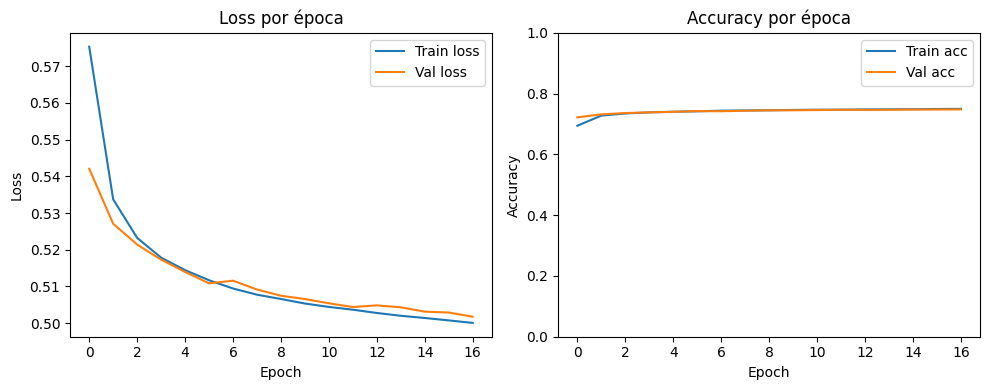

{'used_dim': 32, 'n_blocks': 2, 'opt_name': 'Adam', 'dropout': 0.0, 'use_batchnorm': False, 'l2_reg': 0.0, 'TrainAcc_mean': 0.7408917967010947, 'TrainLoss_mean': 0.5129633047771455, 'BestEpoch': 12, 'BestValAcc': 0.7478449940681458, 'TestAcc': 0.7481120228767395, 'TestLoss': 0.502437949180603, 'Execution_time': 3314.045809000032}

=== used_dim = 32 | n_blocks = 2 |  Optimizer = Adam | Dropout = 0.0 | BatchNorm = False | L2 = 1e-05 ===

Epoch 1/25
TrainLoss=0.5793  TrainAcc=0.6927  ValLoss=0.5442  ValAcc=0.7217

Epoch 2/25
TrainLoss=0.5350  TrainAcc=0.7291  ValLoss=0.5289  ValAcc=0.7320

Epoch 3/25
TrainLoss=0.5240  TrainAcc=0.7359  ValLoss=0.5216  ValAcc=0.7366

Epoch 4/25
TrainLoss=0.5185  TrainAcc=0.7392  ValLoss=0.5179  ValAcc=0.7400

Epoch 5/25
TrainLoss=0.5150  TrainAcc=0.7415  ValLoss=0.5134  ValAcc=0.7428

Epoch 6/25
TrainLoss=0.5125  TrainAcc=0.7430  ValLoss=0.5128  ValAcc=0.7430

Epoch 7/25
TrainLoss=0.5108  TrainAcc=0.7443  ValLoss=0.5102  ValAcc=0.7446

Epoch 8/25
TrainLoss=

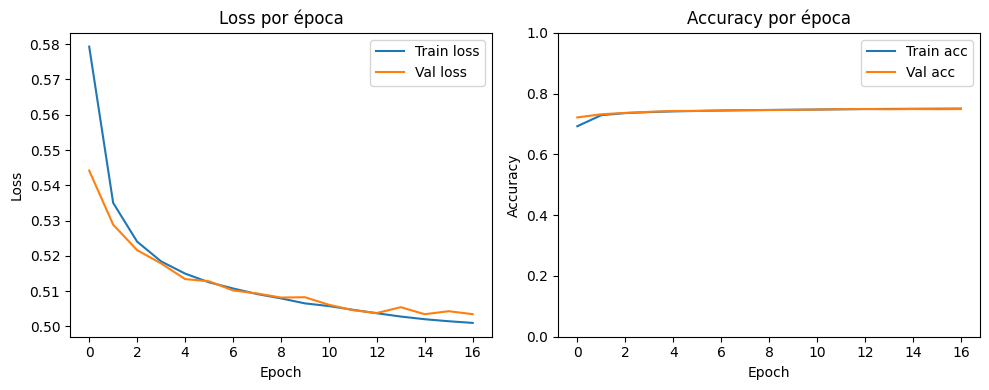

{'used_dim': 32, 'n_blocks': 2, 'opt_name': 'Adam', 'dropout': 0.0, 'use_batchnorm': False, 'l2_reg': 1e-05, 'TrainAcc_mean': 0.7417735702851239, 'TrainLoss_mean': 0.514146787701775, 'BestEpoch': 12, 'BestValAcc': 0.749364972114563, 'TestAcc': 0.7491580247879028, 'TestLoss': 0.5013170838356018, 'Execution_time': 3317.999161399901}


In [149]:
for (used_dim, n_blocks, opt_name, dropout, use_batchnorm, l2_lambda) in hyperparams2[:2]:
    model, best_weights, result = fit_residual(used_dim, n_blocks, opt_name, dropout, use_batchnorm, l2_lambda)
    models2.append((model, best_weights))
    results2.append(result)


=== used_dim = 64 | n_blocks = 2 |  Optimizer = Adam | Dropout = 0.0 | BatchNorm = False | L2 = 0.0 ===

Epoch 1/25
TrainLoss=0.5585  TrainAcc=0.7088  ValLoss=0.5293  ValAcc=0.7316

Epoch 2/25
TrainLoss=0.5199  TrainAcc=0.7372  ValLoss=0.5129  ValAcc=0.7420

Epoch 3/25
TrainLoss=0.5081  TrainAcc=0.7445  ValLoss=0.5060  ValAcc=0.7460

Epoch 4/25
TrainLoss=0.5020  TrainAcc=0.7488  ValLoss=0.5027  ValAcc=0.7483

Epoch 5/25
TrainLoss=0.4982  TrainAcc=0.7510  ValLoss=0.4977  ValAcc=0.7518

Epoch 6/25
TrainLoss=0.4954  TrainAcc=0.7528  ValLoss=0.4963  ValAcc=0.7528

Epoch 7/25
TrainLoss=0.4932  TrainAcc=0.7544  ValLoss=0.4970  ValAcc=0.7521

Epoch 8/25
TrainLoss=0.4916  TrainAcc=0.7555  ValLoss=0.4944  ValAcc=0.7544

Epoch 9/25
TrainLoss=0.4900  TrainAcc=0.7564  ValLoss=0.4930  ValAcc=0.7545

Epoch 10/25
TrainLoss=0.4889  TrainAcc=0.7573  ValLoss=0.4913  ValAcc=0.7561

Epoch 11/25
TrainLoss=0.4877  TrainAcc=0.7579  ValLoss=0.4927  ValAcc=0.7547

Epoch 12/25
TrainLoss=0.4866  TrainAcc=0.7589

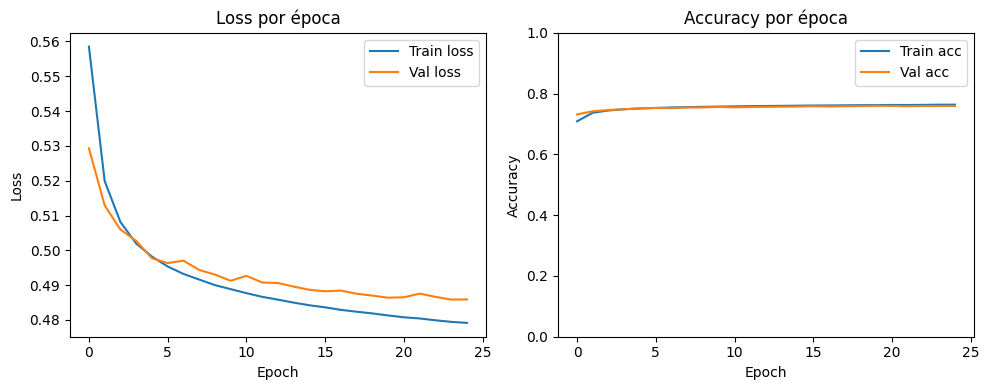

{'used_dim': 64, 'n_blocks': 2, 'opt_name': 'Adam', 'dropout': 0.0, 'use_batchnorm': False, 'l2_reg': 0.0, 'TrainAcc_mean': 0.755412757396698, 'TrainLoss_mean': 0.4914833815216064, 'BestEpoch': 20, 'BestValAcc': 0.7597349882125854, 'TestAcc': 0.7594580054283142, 'TestLoss': 0.48594212532043457, 'Execution_time': 5118.866182000143}

=== used_dim = 64 | n_blocks = 2 |  Optimizer = Adam | Dropout = 0.0 | BatchNorm = False | L2 = 1e-05 ===

Epoch 1/25
TrainLoss=0.5606  TrainAcc=0.7091  ValLoss=0.5318  ValAcc=0.7308

Epoch 2/25
TrainLoss=0.5229  TrainAcc=0.7373  ValLoss=0.5161  ValAcc=0.7420

Epoch 3/25
TrainLoss=0.5115  TrainAcc=0.7448  ValLoss=0.5074  ValAcc=0.7473

Epoch 4/25
TrainLoss=0.5053  TrainAcc=0.7491  ValLoss=0.5053  ValAcc=0.7483

Epoch 5/25
TrainLoss=0.5019  TrainAcc=0.7514  ValLoss=0.5026  ValAcc=0.7510

Epoch 6/25
TrainLoss=0.4993  TrainAcc=0.7530  ValLoss=0.4997  ValAcc=0.7536

Epoch 7/25
TrainLoss=0.4974  TrainAcc=0.7547  ValLoss=0.4995  ValAcc=0.7534

Epoch 8/25
TrainLoss

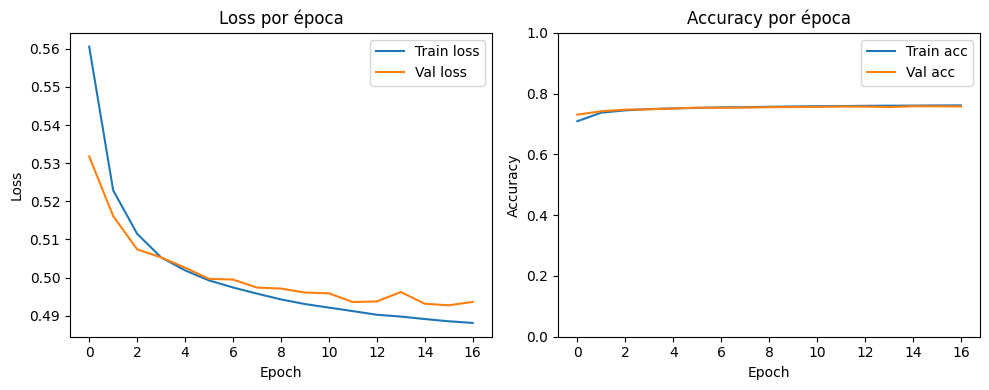

{'used_dim': 64, 'n_blocks': 2, 'opt_name': 'Adam', 'dropout': 0.0, 'use_batchnorm': False, 'l2_reg': 1e-05, 'TrainAcc_mean': 0.7523157386218801, 'TrainLoss_mean': 0.5006564121577319, 'BestEpoch': 12, 'BestValAcc': 0.7583975195884705, 'TestAcc': 0.7574620246887207, 'TestLoss': 0.4877987504005432, 'Execution_time': 3294.274396300083}


In [150]:
for (used_dim, n_blocks, opt_name, dropout, use_batchnorm, l2_lambda) in hyperparams2[2:4]:
    model, best_weights, result = fit_residual(used_dim, n_blocks, opt_name, dropout, use_batchnorm, l2_lambda)
    models2.append((model, best_weights))
    results2.append(result)


=== used_dim = 64 | n_blocks = 2 |  Optimizer = Adam | Dropout = 0.0 | BatchNorm = True | L2 = 0.0 ===

Epoch 1/25
TrainLoss=0.5601  TrainAcc=0.7064  ValLoss=0.5256  ValAcc=0.7336

Epoch 2/25
TrainLoss=0.5175  TrainAcc=0.7385  ValLoss=0.5094  ValAcc=0.7437

Epoch 3/25
TrainLoss=0.5057  TrainAcc=0.7461  ValLoss=0.5020  ValAcc=0.7486

Epoch 4/25
TrainLoss=0.5003  TrainAcc=0.7498  ValLoss=0.4994  ValAcc=0.7499

Epoch 5/25
TrainLoss=0.4966  TrainAcc=0.7521  ValLoss=0.4956  ValAcc=0.7528

Epoch 6/25
TrainLoss=0.4942  TrainAcc=0.7537  ValLoss=0.4934  ValAcc=0.7545

Epoch 7/25
TrainLoss=0.4924  TrainAcc=0.7550  ValLoss=0.4929  ValAcc=0.7545

Epoch 8/25
TrainLoss=0.4909  TrainAcc=0.7561  ValLoss=0.4938  ValAcc=0.7541

Epoch 9/25
TrainLoss=0.4895  TrainAcc=0.7569  ValLoss=0.4911  ValAcc=0.7552

Epoch 10/25
TrainLoss=0.4885  TrainAcc=0.7573  ValLoss=0.4895  ValAcc=0.7563

Epoch 11/25
TrainLoss=0.4873  TrainAcc=0.7581  ValLoss=0.4888  ValAcc=0.7569

Epoch 12/25
TrainLoss=0.4864  TrainAcc=0.7590 

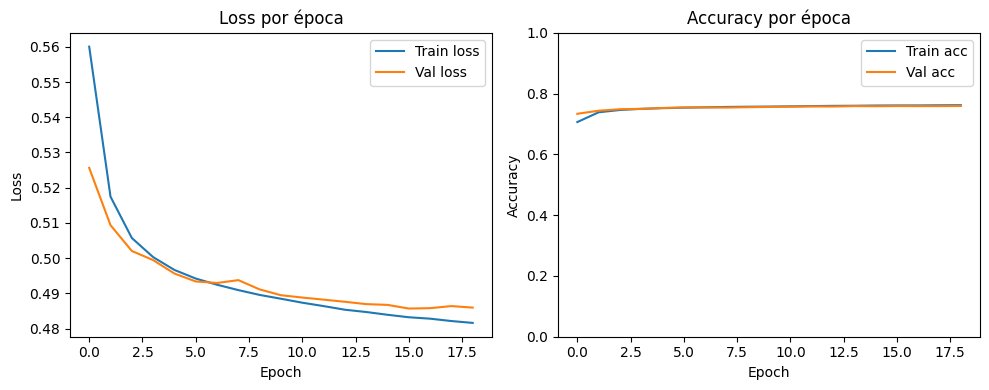

{'used_dim': 64, 'n_blocks': 2, 'opt_name': 'Adam', 'dropout': 0.0, 'use_batchnorm': True, 'l2_reg': 0.0, 'TrainAcc_mean': 0.7534342878743222, 'TrainLoss_mean': 0.494375904819087, 'BestEpoch': 14, 'BestValAcc': 0.7592300176620483, 'TestAcc': 0.759198009967804, 'TestLoss': 0.4859240651130676, 'Execution_time': 6815.399947500089}

=== used_dim = 64 | n_blocks = 2 |  Optimizer = Adam | Dropout = 0.0 | BatchNorm = True | L2 = 1e-05 ===

Epoch 1/25
TrainLoss=0.5650  TrainAcc=0.7048  ValLoss=0.5302  ValAcc=0.7318

Epoch 2/25
TrainLoss=0.5215  TrainAcc=0.7382  ValLoss=0.5162  ValAcc=0.7424

Epoch 3/25
TrainLoss=0.5109  TrainAcc=0.7451  ValLoss=0.5070  ValAcc=0.7480

Epoch 4/25
TrainLoss=0.5052  TrainAcc=0.7491  ValLoss=0.5041  ValAcc=0.7501

Epoch 5/25
TrainLoss=0.5015  TrainAcc=0.7518  ValLoss=0.5007  ValAcc=0.7523

Epoch 6/25
TrainLoss=0.4991  TrainAcc=0.7534  ValLoss=0.4987  ValAcc=0.7540

Epoch 7/25
TrainLoss=0.4970  TrainAcc=0.7549  ValLoss=0.4975  ValAcc=0.7545

Epoch 8/25
TrainLoss=0.4

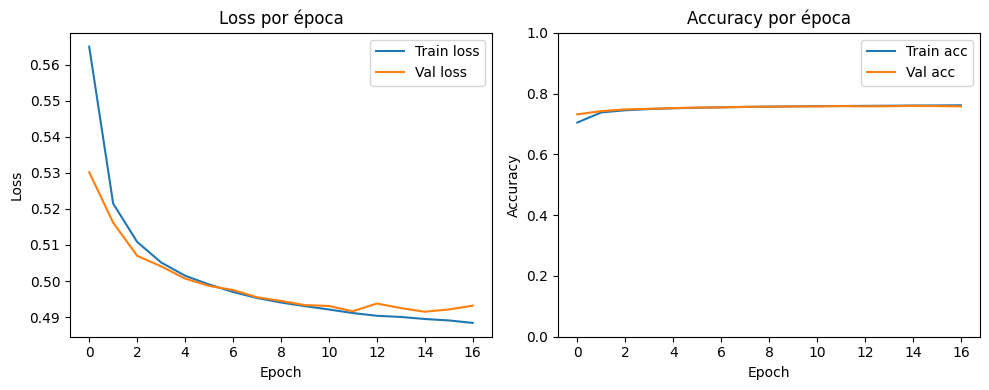

{'used_dim': 64, 'n_blocks': 2, 'opt_name': 'Adam', 'dropout': 0.0, 'use_batchnorm': True, 'l2_reg': 1e-05, 'TrainAcc_mean': 0.7523513681748334, 'TrainLoss_mean': 0.5007719969962625, 'BestEpoch': 12, 'BestValAcc': 0.7595999836921692, 'TestAcc': 0.7599920034408569, 'TestLoss': 0.4854393005371094, 'Execution_time': 6545.0026475000195}


In [151]:
for (used_dim, n_blocks, opt_name, dropout, use_batchnorm, l2_lambda) in hyperparams2[4:6]:
    model, best_weights, result = fit_residual(used_dim, n_blocks, opt_name, dropout, use_batchnorm, l2_lambda)
    models2.append((model, best_weights))
    results2.append(result)


=== used_dim = 128 | n_blocks = 2 |  Optimizer = Adam | Dropout = 0.0 | BatchNorm = False | L2 = 0.0 ===

Epoch 1/25
TrainLoss=0.5452  TrainAcc=0.7186  ValLoss=0.5193  ValAcc=0.7378

Epoch 2/25
TrainLoss=0.5083  TrainAcc=0.7451  ValLoss=0.5016  ValAcc=0.7485

Epoch 3/25
TrainLoss=0.4974  TrainAcc=0.7517  ValLoss=0.4952  ValAcc=0.7532

Epoch 4/25
TrainLoss=0.4911  TrainAcc=0.7559  ValLoss=0.4918  ValAcc=0.7563

Epoch 5/25
TrainLoss=0.4869  TrainAcc=0.7586  ValLoss=0.4905  ValAcc=0.7565

Epoch 6/25
TrainLoss=0.4833  TrainAcc=0.7609  ValLoss=0.4878  ValAcc=0.7589

Epoch 7/25
TrainLoss=0.4806  TrainAcc=0.7628  ValLoss=0.4867  ValAcc=0.7590

Epoch 8/25
TrainLoss=0.4782  TrainAcc=0.7643  ValLoss=0.4859  ValAcc=0.7599

Epoch 9/25
TrainLoss=0.4761  TrainAcc=0.7656  ValLoss=0.4847  ValAcc=0.7605

Epoch 10/25
TrainLoss=0.4743  TrainAcc=0.7668  ValLoss=0.4839  ValAcc=0.7612

Epoch 11/25
TrainLoss=0.4725  TrainAcc=0.7678  ValLoss=0.4846  ValAcc=0.7608

Epoch 12/25
TrainLoss=0.4709  TrainAcc=0.769

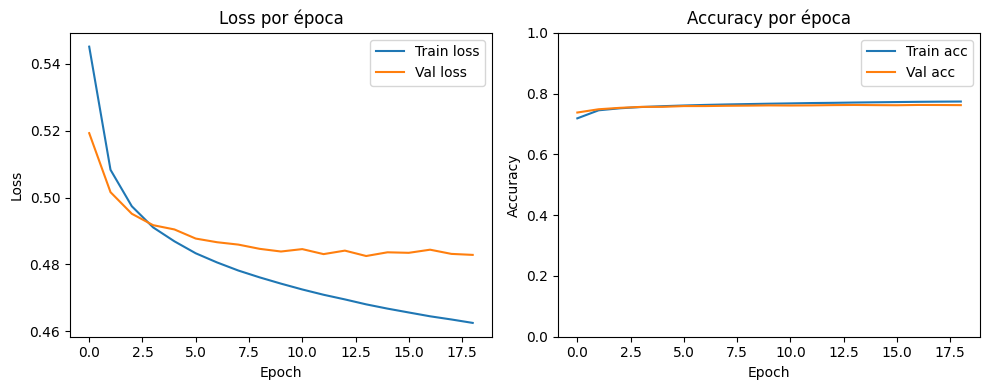

{'used_dim': 128, 'n_blocks': 2, 'opt_name': 'Adam', 'dropout': 0.0, 'use_batchnorm': False, 'l2_reg': 0.0, 'TrainAcc_mean': 0.7627152643705669, 'TrainLoss_mean': 0.480288439396808, 'BestEpoch': 14, 'BestValAcc': 0.7626799941062927, 'TestAcc': 0.7625359892845154, 'TestLoss': 0.48157283663749695, 'Execution_time': 3982.401821800042}

=== used_dim = 128 | n_blocks = 2 |  Optimizer = Adam | Dropout = 0.0 | BatchNorm = False | L2 = 1e-05 ===

Epoch 1/25
TrainLoss=0.5496  TrainAcc=0.7194  ValLoss=0.5244  ValAcc=0.7370

Epoch 2/25
TrainLoss=0.5140  TrainAcc=0.7446  ValLoss=0.5077  ValAcc=0.7487

Epoch 3/25
TrainLoss=0.5039  TrainAcc=0.7517  ValLoss=0.5018  ValAcc=0.7538

Epoch 4/25
TrainLoss=0.4982  TrainAcc=0.7554  ValLoss=0.5005  ValAcc=0.7551

Epoch 5/25
TrainLoss=0.4946  TrainAcc=0.7580  ValLoss=0.4967  ValAcc=0.7565

Epoch 6/25
TrainLoss=0.4917  TrainAcc=0.7601  ValLoss=0.4957  ValAcc=0.7576

Epoch 7/25
TrainLoss=0.4894  TrainAcc=0.7618  ValLoss=0.4928  ValAcc=0.7604

Epoch 8/25
TrainLo

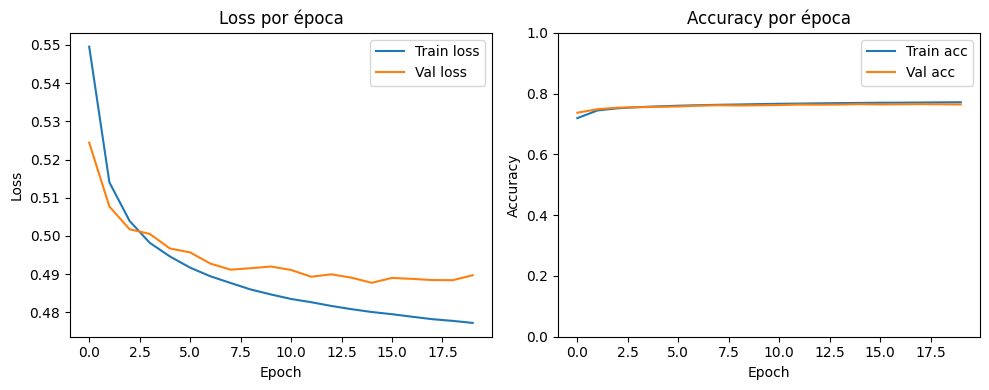

{'used_dim': 128, 'n_blocks': 2, 'opt_name': 'Adam', 'dropout': 0.0, 'use_batchnorm': False, 'l2_reg': 1e-05, 'TrainAcc_mean': 0.7618649393320084, 'TrainLoss_mean': 0.49000829455661776, 'BestEpoch': 15, 'BestValAcc': 0.7653300166130066, 'TestAcc': 0.7665600180625916, 'TestLoss': 0.47648414969444275, 'Execution_time': 4435.7010766998865}


In [152]:
for (used_dim, n_blocks, opt_name, dropout, use_batchnorm, l2_lambda) in hyperparams2[6:8]:
    model, best_weights, result = fit_residual(used_dim, n_blocks, opt_name, dropout, use_batchnorm, l2_lambda)
    models2.append((model, best_weights))
    results2.append(result)


=== used_dim = 128 | n_blocks = 2 |  Optimizer = Adam | Dropout = 0.0 | BatchNorm = True | L2 = 0.0 ===

Epoch 1/25
TrainLoss=0.5477  TrainAcc=0.7167  ValLoss=0.5153  ValAcc=0.7401

Epoch 2/25
TrainLoss=0.5082  TrainAcc=0.7447  ValLoss=0.5022  ValAcc=0.7482

Epoch 3/25
TrainLoss=0.4977  TrainAcc=0.7514  ValLoss=0.4926  ValAcc=0.7546

Epoch 4/25
TrainLoss=0.4917  TrainAcc=0.7552  ValLoss=0.4907  ValAcc=0.7564

Epoch 5/25
TrainLoss=0.4876  TrainAcc=0.7582  ValLoss=0.4893  ValAcc=0.7568

Epoch 6/25
TrainLoss=0.4842  TrainAcc=0.7606  ValLoss=0.4842  ValAcc=0.7606

Epoch 7/25
TrainLoss=0.4810  TrainAcc=0.7628  ValLoss=0.4854  ValAcc=0.7599

Epoch 8/25
TrainLoss=0.4786  TrainAcc=0.7641  ValLoss=0.4815  ValAcc=0.7626

Epoch 9/25
TrainLoss=0.4764  TrainAcc=0.7656  ValLoss=0.4853  ValAcc=0.7603

Epoch 10/25
TrainLoss=0.4747  TrainAcc=0.7664  ValLoss=0.4808  ValAcc=0.7625

Epoch 11/25
TrainLoss=0.4729  TrainAcc=0.7678  ValLoss=0.4793  ValAcc=0.7639

Epoch 12/25
TrainLoss=0.4713  TrainAcc=0.7686

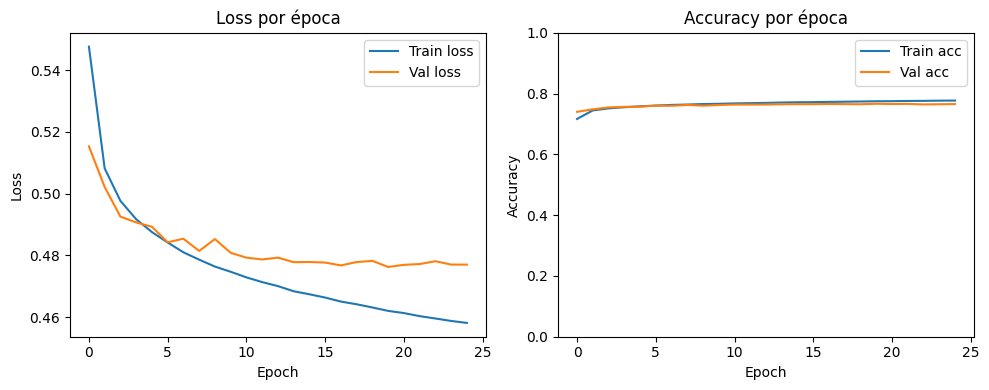

{'used_dim': 128, 'n_blocks': 2, 'opt_name': 'Adam', 'dropout': 0.0, 'use_batchnorm': True, 'l2_reg': 0.0, 'TrainAcc_mean': 0.7656681537628174, 'TrainLoss_mean': 0.47585010810546874, 'BestEpoch': 20, 'BestValAcc': 0.7665975093841553, 'TestAcc': 0.7672460079193115, 'TestLoss': 0.47549968957901, 'Execution_time': 9969.604751899838}

=== used_dim = 128 | n_blocks = 2 |  Optimizer = Adam | Dropout = 0.0 | BatchNorm = True | L2 = 1e-05 ===

Epoch 1/25
TrainLoss=0.5521  TrainAcc=0.7179  ValLoss=0.5213  ValAcc=0.7397

Epoch 2/25
TrainLoss=0.5145  TrainAcc=0.7444  ValLoss=0.5085  ValAcc=0.7485

Epoch 3/25
TrainLoss=0.5050  TrainAcc=0.7514  ValLoss=0.5030  ValAcc=0.7536

Epoch 4/25
TrainLoss=0.4998  TrainAcc=0.7550  ValLoss=0.4995  ValAcc=0.7553

Epoch 5/25
TrainLoss=0.4960  TrainAcc=0.7578  ValLoss=0.4965  ValAcc=0.7577

Epoch 6/25
TrainLoss=0.4929  TrainAcc=0.7597  ValLoss=0.4983  ValAcc=0.7575

Epoch 7/25
TrainLoss=0.4904  TrainAcc=0.7618  ValLoss=0.4901  ValAcc=0.7622

Epoch 8/25
TrainLoss=

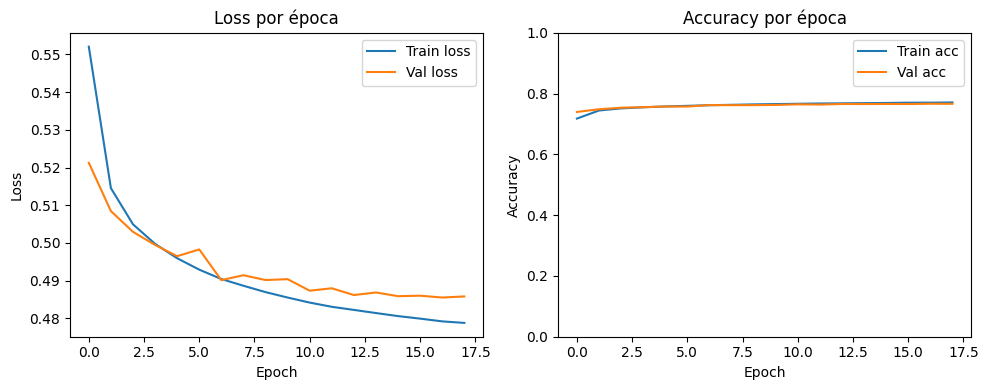

{'used_dim': 128, 'n_blocks': 2, 'opt_name': 'Adam', 'dropout': 0.0, 'use_batchnorm': True, 'l2_reg': 1e-05, 'TrainAcc_mean': 0.760689828130934, 'TrainLoss_mean': 0.4922926724015342, 'BestEpoch': 13, 'BestValAcc': 0.7666149735450745, 'TestAcc': 0.7655799984931946, 'TestLoss': 0.47581806778907776, 'Execution_time': 7343.587068699999}


In [153]:
for (used_dim, n_blocks, opt_name, dropout, use_batchnorm, l2_lambda) in hyperparams2[8:10]:
    model, best_weights, result = fit_residual(used_dim, n_blocks, opt_name, dropout, use_batchnorm, l2_lambda)
    models2.append((model, best_weights))
    results2.append(result)

In [ ]:
SAVE_DIR_2 = "saved_models_hp2"
os.makedirs(SAVE_DIR_2, exist_ok=True)

y_true2 = np.asarray(y_test, dtype=int).ravel()

for i, (model, best_weights) in enumerate(models2):
    print(f"\n[POST 2] Calculando métricas y guardando modelo2 #{i} ...")

    model.set_weights(best_weights)

    y_probabilities = model.predict(X_test_norm, verbose=0)
    y_scores = y_probabilities.ravel()

    y_pred = np.zeros_like(y_scores, dtype=int)
    for idx, prob in enumerate(y_scores):
        y_pred[idx] = 1 if prob >= 0.5 else 0

    bal_acc = balanced_accuracy_score(y_true2, y_pred)
    f1      = f1_score(y_true2, y_pred)

    results2[i]["TestBalAcc"] = float(bal_acc)
    results2[i]["TestF1"]     = float(f1)

    r = results2[i]
    model_filename = (
        f"residual_hp2_dim{int(r['used_dim'])}"
        f"_blocks{int(r['n_blocks'])}"
        f"_opt{r['opt_name']}"
        f"_do{r['dropout']}"
        f"_bn{int(r['use_batchnorm'])}"
        f"_l2{r['l2_reg']}.keras"
    )

    model_path = os.path.join(SAVE_DIR_2, model_filename)
    model.save(model_path)



[POST 2] Calculando métricas y guardando modelo2 #0 ...

[POST 2] Calculando métricas y guardando modelo2 #1 ...

[POST 2] Calculando métricas y guardando modelo2 #2 ...

[POST 2] Calculando métricas y guardando modelo2 #3 ...

[POST 2] Calculando métricas y guardando modelo2 #4 ...

[POST 2] Calculando métricas y guardando modelo2 #5 ...

[POST 2] Calculando métricas y guardando modelo2 #6 ...

[POST 2] Calculando métricas y guardando modelo2 #7 ...

[POST 2] Calculando métricas y guardando modelo2 #8 ...

[POST 2] Calculando métricas y guardando modelo2 #9 ...


In [5]:
# df_resultados2 = pd.DataFrame(results2)
df_resultados2 = pd.read_csv("resultados_higgs_residual_hyperparams2.csv")

df_resultados2 = df_resultados2[
    [
        "used_dim", "n_blocks", "opt_name", "dropout", "use_batchnorm", "l2_reg",
        "TrainAcc_mean", "TrainLoss_mean",
        "BestEpoch", "BestValAcc",
        "TestAcc", "TestBalAcc", "TestF1", "TestLoss",
        "Execution_time"
    ]
]

# df_resultados2.to_csv("resultados_higgs_residual_hyperparams2.csv", index=False)


col_numericas = df_resultados2.select_dtypes(include="number").columns

df_final2 = (
    df_resultados2.style
        .set_caption("RESULTADOS FINALES - Redes Residuales Higgs")
        .background_gradient(cmap="YlGnBu", subset=["TestAcc"])   
        .background_gradient(cmap="OrRd",    subset=["TestLoss"]) 
        .background_gradient(cmap="YlGnBu", subset=["TestBalAcc"])   
        .background_gradient(cmap="YlGnBu",    subset=["TestF1"]) 
        .highlight_max(color="darkgreen", subset=["TestAcc"]) 
        .highlight_max(color="darkgreen", subset=["TestBalAcc"])   
        .highlight_max(color="darkgreen", subset=["TestF1"])           
        .highlight_max(color="darkred",   subset=["TestLoss"])    
        .format({col: "{:.4g}".format for col in col_numericas})  
        .set_table_attributes('style="width:100%; table-layout:auto;"')
)

In [6]:
df_final2

,used_dim,n_blocks,opt_name,dropout,use_batchnorm,l2_reg,TrainAcc_mean,TrainLoss_mean,BestEpoch,BestValAcc,TestAcc,TestBalAcc,TestF1,TestLoss,Execution_time
0,32,2,Adam,0,False,0,0.7409,0.513,12,0.7478,0.7481,0.7466,0.7644,0.5024,3314
1,32,2,Adam,0,False,1e-05,0.7418,0.5141,12,0.7494,0.7492,0.7481,0.7636,0.5013,3318
2,64,2,Adam,0,False,0,0.7554,0.4915,20,0.7597,0.7595,0.7588,0.7719,0.4859,5119
3,64,2,Adam,0,False,1e-05,0.7523,0.5007,12,0.7584,0.7575,0.7562,0.7723,0.4878,3294
4,64,2,Adam,0,True,0,0.7534,0.4944,14,0.7592,0.7592,0.7567,0.7786,0.4859,6815
5,64,2,Adam,0,True,1e-05,0.7524,0.5008,12,0.7596,0.76,0.7588,0.7745,0.4854,6545
6,128,2,Adam,0,False,0,0.7627,0.4803,14,0.7627,0.7625,0.7615,0.7765,0.4816,3982
7,128,2,Adam,0,False,1e-05,0.7619,0.49,15,0.7653,0.7666,0.7651,0.7817,0.4765,4436
8,128,2,Adam,0,True,0,0.7657,0.4759,20,0.7666,0.7672,0.7656,0.7829,0.4755,9970
9,128,2,Adam,0,True,1e-05,0.7607,0.4923,13,0.7666,0.7656,0.7649,0.7782,0.4758,7344
